In [48]:
import csv
import os
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS

from statsmodels.tsa.tsatools import lagmat
%matplotlib inline

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator as TSG
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, TimeDistributed, BatchNormalization, Activation
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers 
import tensorflow as tf

ts_dir = '/Users/danielfriedman/Desktop/CS109b/final_project/timeseries/github/'
ts_dir = '/Users/joannafriedman/Desktop/CS109b/final_project/timeseries/github/'
ts_dir = '/jupyteruser/31170133/timeseries'
os.chdir(ts_dir)

In [49]:
# # Only run if us_mobility.csv hasn't been created

# global_mob = pd.read_csv('Global_Mobility_Report.csv', dtype = {'sub_region_2':object})
# mob = global_mob[global_mob['country_region'] == 'United States'].drop(columns = ['country_region_code','country_region'])
# mapper1 = {'sub_region_1':'state', 'sub_region_2':'county'}
# mapper2 = pd.Series(index = mob.columns[3:], data = ['retail','grocery','parks','transit','work','residential'])
# mob.rename(columns = mapper1, inplace = True)
# mob.rename(columns = mapper2, inplace = True)
# mob.loc[mob['state'] == 'District of Columbia', 'county'] = 'DC'
# mob = mob[(~pd.isnull(mob['state'])) & (~pd.isnull(mob['county']))].reset_index(drop = True)
# mob['county'] = mob.county.str.replace(' County', '')
# mob['date'] = mob['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d'))
# mob.to_csv('us_mobility.csv', index = False)

In [50]:
mob = pd.read_csv('data/us_mobility.csv')
mob['date'] = mob['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d'))
mob.head()
mob[(mob['state'] == 'New York') & (mob['county'] == 'New York')].head()

state    county       date  retail  grocery  parks  transit  work  \
89341  New York  New York 2020-02-15     2.0     -5.0    0.0     -1.0   0.0   
89342  New York  New York 2020-02-16     6.0     -2.0    4.0      1.0  -2.0   
89343  New York  New York 2020-02-17    -5.0    -12.0   13.0    -25.0 -51.0   
89344  New York  New York 2020-02-18     0.0     -2.0    5.0     -5.0  -6.0   
89345  New York  New York 2020-02-19     2.0     -1.0   15.0     -1.0  -4.0   

       residential  
89341          0.0  
89342          0.0  
89343         10.0  
89344          2.0  
89345          1.0

In [51]:
nyt = pd.read_csv(f'data/us-counties.csv')
nyt['date'] = nyt['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d'))
nyt['county'] = nyt.county.str.replace('City', '').str.strip()
nyt.head()

date     county       state     fips  cases  deaths
0 2020-01-21  Snohomish  Washington  53061.0      1       0
1 2020-01-22  Snohomish  Washington  53061.0      1       0
2 2020-01-23  Snohomish  Washington  53061.0      1       0
3 2020-01-24       Cook    Illinois  17031.0      1       0
4 2020-01-24  Snohomish  Washington  53061.0      1       0

In [52]:
### TODO: match by county better
mobcounties = mob.county.unique()
nytcounties = nyt.county.unique()
print(len([c for c in mobcounties if c not in nytcounties]))
print(len([c for c in nytcounties if c not in mobcounties]))

198
148


In [53]:
mob = mob.merge(nyt, how = 'left', on = ['state','county','date'])
mob['cases'].fillna(0, inplace = True) # if it's nan, that means they hadn't had cases
mob['deaths'].fillna(0, inplace = True) # if it's nan, that means they hadn't had deaths

In [54]:
# REMOVE NY
mob = mob[(mob['state'] != 'New York') | (mob['county'] != 'New York')]
mob.reset_index(drop = True, inplace = True)

#### Get metric of mobility

In [55]:
# Standardize
fullcats = ['grocery','parks','residential','retail','transit','work']
cats = ['grocery','residential','retail','transit','work'] # note: only use these categories for building PCs
ss = SS().fit(mob[fullcats])
mob_standard = pd.DataFrame(ss.transform(mob[fullcats]), columns = fullcats)
mob_standard.fillna(0, inplace = True)

# PCA
N_COMPONENTS = 1
pca = PCA(n_components = N_COMPONENTS).fit(mob_standard)
pcs = ['pc'+str(i) for i in range(N_COMPONENTS)]
mob[pcs] = pd.DataFrame(pca.transform(mob_standard))
mob.head()

state   county       date  retail  grocery  parks  transit  work  \
0  Alabama  Autauga 2020-02-15     5.0      7.0    NaN      NaN  -4.0   
1  Alabama  Autauga 2020-02-16     0.0      1.0  -23.0      NaN  -4.0   
2  Alabama  Autauga 2020-02-17     8.0      0.0    NaN      NaN -27.0   
3  Alabama  Autauga 2020-02-18    -2.0      0.0    NaN      NaN   2.0   
4  Alabama  Autauga 2020-02-19    -2.0      0.0    NaN      NaN   2.0   

   residential  fips  cases  deaths       pc0  
0          NaN   NaN    0.0     0.0  0.808952  
1          NaN   NaN    0.0     0.0  0.475252  
2          5.0   NaN    0.0     0.0  0.070472  
3          0.0   NaN    0.0     0.0  0.927648  
4          0.0   NaN    0.0     0.0  0.927648

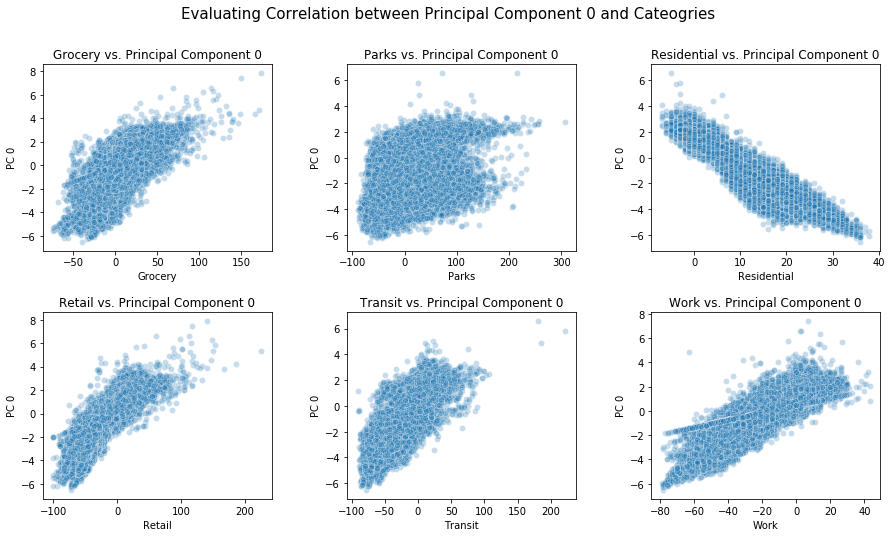

In [56]:
### TODO: double check this 
component = 0
fig, axes = plt.subplots(2, 3, figsize = (15,8))
for i, ax in enumerate(axes.ravel()):
    sns.scatterplot(mob[fullcats[i]], mob[f'pc{component}'], ax = ax, alpha = 0.25);
    ax.set(xlabel = fullcats[i].capitalize(),
           ylabel = 'PC '+str(component), 
           title = fullcats[i].capitalize() + ' vs. Principal Component ' + str(component))
fig.subplots_adjust(hspace = .33, wspace = .33);
fig.suptitle(f'Evaluating Correlation between Principal Component {component} and Cateogries', fontsize = 15);

#### Baseline Model

In [57]:
predictors = pcs
target = 'cases'
predictors = list(predictors) + [target]
mob_nonull = mob[~pd.isnull(mob['cases'])].reset_index(drop = 1) # TODO: 
mob_nonull.head()

state   county       date  retail  grocery  parks  transit  work  \
0  Alabama  Autauga 2020-02-15     5.0      7.0    NaN      NaN  -4.0   
1  Alabama  Autauga 2020-02-16     0.0      1.0  -23.0      NaN  -4.0   
2  Alabama  Autauga 2020-02-17     8.0      0.0    NaN      NaN -27.0   
3  Alabama  Autauga 2020-02-18    -2.0      0.0    NaN      NaN   2.0   
4  Alabama  Autauga 2020-02-19    -2.0      0.0    NaN      NaN   2.0   

   residential  fips  cases  deaths       pc0  
0          NaN   NaN    0.0     0.0  0.808952  
1          NaN   NaN    0.0     0.0  0.475252  
2          5.0   NaN    0.0     0.0  0.070472  
3          0.0   NaN    0.0     0.0  0.927648  
4          0.0   NaN    0.0     0.0  0.927648

In [58]:
nback = 10 # means each prediction will look back nback timesteps
nahead = 3 # means each prediction will be for up to nahead steps ahead
grouper = ['state','county']
grouped = mob_nonull.groupby(grouper)
county_lens = grouped.apply(len).values
nsamples = sum(np.maximum(county_lens - (nback + nahead - 1), 0)) # counts total number of samples we need # note that if it's shorter than nahead + nback, skip it 


In [59]:
# # only run the commented out stuff if X/y/states/counties aren't already saved
# X = np.empty((nsamples, nback, len(predictors)))
# y = np.empty((nsamples, nahead))
# states = []
# counties = []

# index = 0
# for (state, county), data in grouped:
#     if len(data) < nback + nahead:
#         continue
#     for i in range(nback, len(data) - nahead + 1): 
#         X[index] = data.iloc[i-nback: i][predictors]
#         y[index] = data[target].iloc[i:i + nahead]
#         states.append(state)
#         counties.append(county)
#         index += 1
# states = np.array(states)
# counties = np.array(counties)
# np.savetxt(f'models/X{N_COMPONENTS}.csv',X.reshape(nsamples, -1), delimiter = ',')
# np.savetxt(f'models/y{N_COMPONENTS}.csv', y, delimiter = ',')
# np.savetxt(f'models/states{N_COMPONENTS}.csv', states, delimiter = ',', fmt = '%s')
# np.savetxt(f'models/counties{N_COMPONENTS}.csv', counties, delimiter = ',', fmt = '%s')

In [92]:
X = np.loadtxt(f'models/X{N_COMPONENTS}.csv', delimiter = ',').reshape(nsamples, nback, len(predictors))
y = np.loadtxt(f'models/y{N_COMPONENTS}.csv', delimiter = ',')
states = np.loadtxt(f'models/states{N_COMPONENTS}.csv', delimiter = ',', dtype = str)
counties = np.loadtxt(f'models/counties{N_COMPONENTS}.csv', delimiter = ',', dtype = str)

In [100]:
# To enact a maximum limit
MAXVAL = 5000
smallboys = y.max(1) < MAXVAL
X = X[smallboys]
y = y[smallboys]
counties = counties[smallboys]
states = states[smallboys]

In [101]:
nunits = 500
interunits = 100
droprate = 0.15
optimizer = optimizers.Adam(learning_rate = 0.000025)

inputs = Input(shape = (nback, len(predictors)), name = 'inputs')
# layer = LSTM(units = nunits, return_sequences = True, name = 'lstm1', activation = 'tanh')(inputs)
# layer = Dropout(rate = droprate, name = 'drop1')(layer)
layer = LSTM(units = nunits, return_sequences = False, name = 'lstm1', activation = 'tanh')(inputs)
layer = Dropout(rate = droprate, name = 'drop1')(layer)
layer = Dense(interunits, activation = 'relu', name = 'inters')(layer)
outputs = Dense(nahead, activation = 'relu', name = 'outputs')(layer)
mod = Model(inputs, outputs, name = 'mod')
mod.compile(optimizer, loss = 'mean_squared_error')
mod.summary()

Model: "mod"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 10, 2)]           0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 500)               1006000   
_________________________________________________________________
drop1 (Dropout)              (None, 500)               0         
_________________________________________________________________
inters (Dense)               (None, 100)               50100     
_________________________________________________________________
outputs (Dense)              (None, 3)                 303       
Total params: 1,056,403
Trainable params: 1,056,403
Non-trainable params: 0
_________________________________________________________________


In [102]:
epochs = 40
batch_size = 64
validation_split = 0.15
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5)]
verbose = 1

history = mod.fit(X,
                  y,
                  batch_size = batch_size,
                  epochs = epochs,
                  validation_split = validation_split,
                  callbacks = callbacks,
                  verbose = verbose)



Train on 100715 samples, validate on 17774 samples
Epoch 1/40
100715/100715 [==============================] - 19s 186us/sample - loss: 23339.2246 - val_loss: 11070.9079
Epoch 2/40
100715/100715 [==============================] - 16s 160us/sample - loss: 19741.9501 - val_loss: 9261.0168
Epoch 3/40
100715/100715 [==============================] - 16s 160us/sample - loss: 17024.8691 - val_loss: 7977.8123
Epoch 4/40
100715/100715 [==============================] - 16s 159us/sample - loss: 14810.8725 - val_loss: 6847.7090
Epoch 5/40
100715/100715 [==============================] - 16s 158us/sample - loss: 12874.4843 - val_loss: 5891.5201
Epoch 6/40
100715/100715 [==============================] - 16s 159us/sample - loss: 11219.8951 - val_loss: 5106.9490
Epoch 7/40
100715/100715 [==============================] - 16s 155us/sample - loss: 9737.7308 - val_loss: 4388.1960
Epoch 8/40
100715/100715 [==============================] - 16s 156us/sample - loss: 8465.3220 - val_loss: 3785.7190
Epoch 

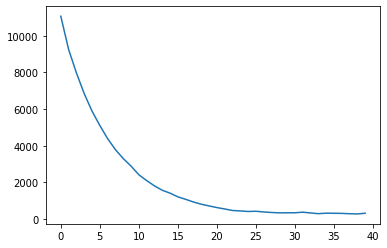

In [103]:
sns.lineplot(range(len(history.history['val_loss'])), history.history['val_loss']);

In [104]:
# mod.save('models/reshaped.h5')  
# mod = load_model('models/reshaped.h5')
yhat = mod.predict(X)

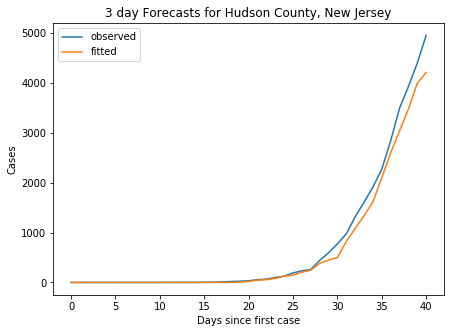

In [105]:
county = 'Hudson'
state = 'New Jersey'


countyy = y[(counties == county) & (states == state)]
countyyhat = yhat[(counties == county) & (states == state)]
county_obs = len(countyy)

fig, ax = plt.subplots(figsize = (7,5))
d = 2
sns.lineplot(range(county_obs), countyy[:,d], label = 'observed')
sns.lineplot(range(county_obs), countyyhat[:,d], label = 'fitted')
ax.set(xlabel = 'Days since first case', ylabel = 'Cases', title = f'{d + 1} day Forecasts for {county} County, {state}');




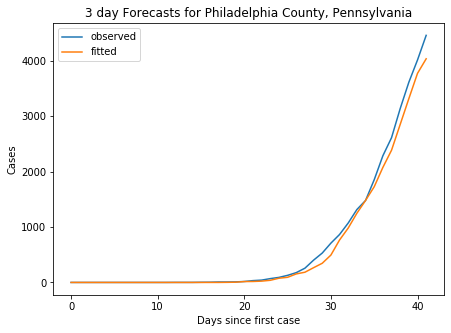

In [106]:
county = 'Philadelphia'
state = 'Pennsylvania'


countyy = y[(counties == county) & (states == state)]
countyyhat = yhat[(counties == county) & (states == state)]
county_obs = len(countyy)

fig, ax = plt.subplots(figsize = (7,5))
d = 2
sns.lineplot(range(county_obs), countyy[:,d], label = 'observed')
sns.lineplot(range(county_obs), countyyhat[:,d], label = 'fitted')
ax.set(xlabel = 'Days since first case', ylabel = 'Cases', title = f'{d + 1} day Forecasts for {county} County, {state}');




#### Parameters that kinda worked
- :P
    - nunits = 100
    - interunits = 32
    - droprate = 0.15
    - tanh, tanh, relu, relu
- :O *** (consistent val loss around 300 for 1 PC, 300 for 2 PC, 300 for 3 PC)
    - units = 500
    - interunits = 32
    - droprate = 0.15
    - tanh, relu, relu (single LSTM layer)
    - lr = 0.00005
    - ~10-15 epochs

#### Notes

- Standardize/centralize
- *Add in other PCS!*
- change MACVAL —opposite effect as expected
- Lag/per capita
- Batch normalization
- batch size
- Change nback
- Add second LSTM layer and lower LR
- add NY back 
- log transfo
- toggle intermediate layer
- try without 0s